In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time

In [236]:
import hackeeg
from hackeeg import ads1299
SERIAL_PORT_PATH = "/dev/cu.usbmodem143301"
SAMPLES_PER_SECOND = ads1299.HIGH_RES_4k_SPS
GAIN = ads1299.GAIN_1X
CHANNELS = 8

In [237]:
# Configure ADS1299
hackeeg = hackeeg.HackEEGBoard(serial_port_path=SERIAL_PORT_PATH)
hackeeg.connect()
hackeeg.blink_board_led()
hackeeg.sdatac()
hackeeg.reset()
hackeeg.disable_all_channels()

# Set sampling rate
hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)


for i in range(1, 9):
    hackeeg.wreg(ads1299.CHnSET + i, ads1299.ELECTRODE_INPUT | GAIN)

# Differential mode - each channel is the differential voltage between adjacent electrodes
hackeeg.wreg(ads1299.MISC1, ads1299.MISC1_const)
# For single-ended mode, uncomment the following line to set the SRB1 bit,
# which sends mid-supply voltage to the N inputs
# hackeeg.wreg(ads1299.MISC1, ads1299.SRB1 | ads1299.MISC1_const)

# hackeeg.wreg(ads1299.CONFIG4, ads1299.PD_LOFF_COMP | ads1299.CONFIG4_const)
# hackeeg.wreg(ads1299.LOFF_SENSP, 0b11111111)
# hackeeg.wreg(ads1299.LOFF_SENSN, 0b11111111)


# Set positive electrode of channel 8 to drive bias
# hackeeg.wreg(ads1299.CH8SET, ads1299.BIAS_DRP)

# Route BIASIN to be measured at channel 8 with respect to BIASREF
# hackeeg.wreg(ads1299.CH8SET, ads1299.RLD_INPUT)

# Choose bias as an average of all channels but channel 8
hackeeg.wreg(ads1299.BIAS_SENSP, 0b01111111)
hackeeg.wreg(ads1299.BIAS_SENSN, 0b01111111)
# Use internal BIASREF signal source and turn on bias amplifier
# route BIASOUT to bias electrode: JP9: 1-2, JP6: NC (not connected)
# route BIASOUT to BIASIN: JP9: 2-3
hackeeg.wreg(ads1299.CONFIG3, ads1299.BIASREF_INT | ads1299.PD_BIAS | ads1299.CONFIG3_const)



{'STATUS_CODE': 200, 'STATUS_TEXT': 'Ok'}

In [238]:
# Read data continuously for 5 seconds
hackeeg.messagepack_mode()
hackeeg.blink_board_led()
hackeeg.start()
hackeeg.rdatac()

print("Flex!")

samples = []
timestamp_contraction = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        samples.append(result)
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

Flex!
Sampling complete


In [239]:
# Process samples
channel_data = np.empty((9, len(samples)))
for i, s in enumerate(samples):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        timestamp = s.get('timestamp')
        data = s.get('channel_data')
        channel_data[0, i] = timestamp
        for channel in range(1,9):
            channel_data[channel, i] = data[channel-1]
channel_data = channel_data.astype(np.float64)
np.save('channel_data', channel_data)

<AxesSubplot:>

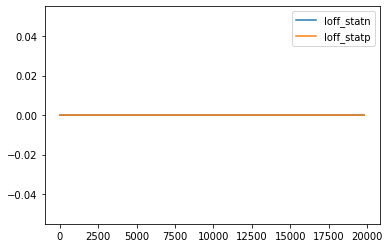

In [257]:
loff_statn = map(lambda x: x.get("loff_statn"), samples)
loff_statp = map(lambda x: x.get("loff_statp"), samples)
loff = pd.DataFrame({"loff_statn": loff_statn, "loff_statp": loff_statp})
loff.plot()

<AxesSubplot:xlabel='timestamp'>

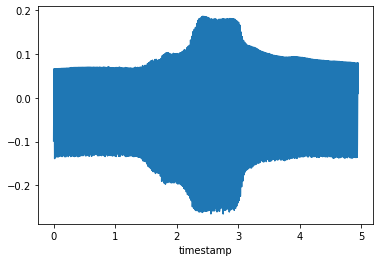

In [335]:
df = pd.DataFrame(data=channel_data.T).set_index(0)
df *= 2.5
df /= 2**23
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df.channel_4.plot()


Text(0.5, 1.0, 'FFT of signal')

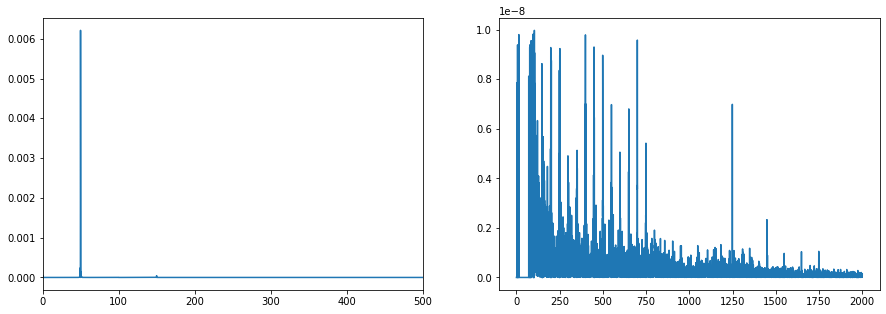

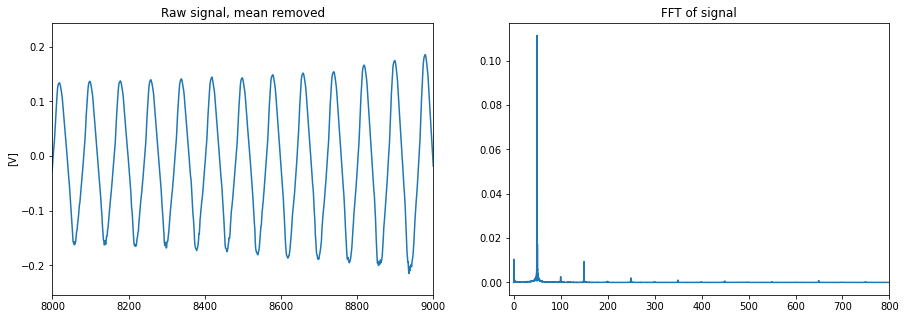

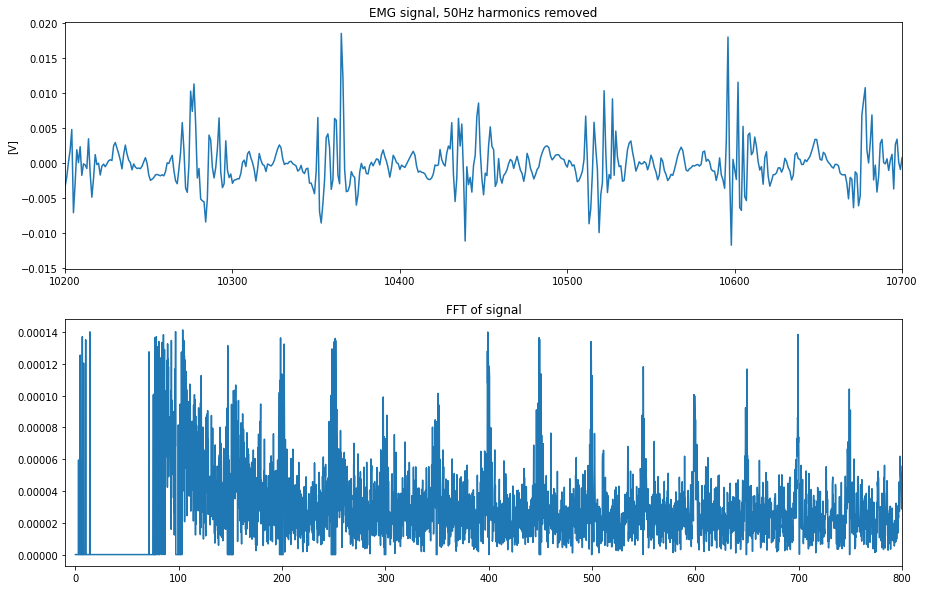

In [340]:
import scipy
from scipy import fftpack
sampling_rate = 4000
T = 1 / sampling_rate

y = df.channel_4
y = y.to_numpy()
y = y[100:]
y = y - y.mean()
N = len(y)
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_fft = scipy.fftpack.fft(y)

psd = y_fft * np.conj(y_fft)/N

threshold = 0.0001
psd_idxs = psd < threshold
psd_clean = psd * psd_idxs
y_fft_clean = psd_idxs * y_fft
signal = scipy.fftpack.ifft(y_fft_clean)
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(psd[:N//2]))
plt.xlim(0,500)
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(psd_clean[:N//2]))

y_fft = 2.0/N * np.abs(y_fft[:N//2])

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.xlim(8000, 9000)
plt.title('Raw signal, mean removed')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(x, y_fft)
plt.xlim(-10, 800)
plt.title('FFT of signal')

y_fft_clean = 2.0/N * np.abs(y_fft_clean[:N//2])
signal = signal[100:-100]
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.xlim(10200,10700)
plt.title('EMG signal, 50Hz harmonics removed')
plt.ylabel('[V]')
plt.subplot(2, 1, 2)
plt.plot(x, y_fft_clean)
plt.xlim(-10, 800)
plt.title('FFT of signal')


 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

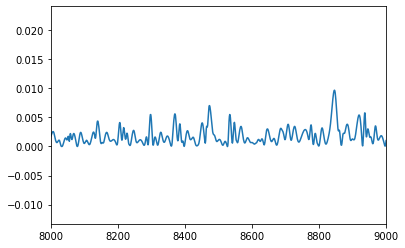

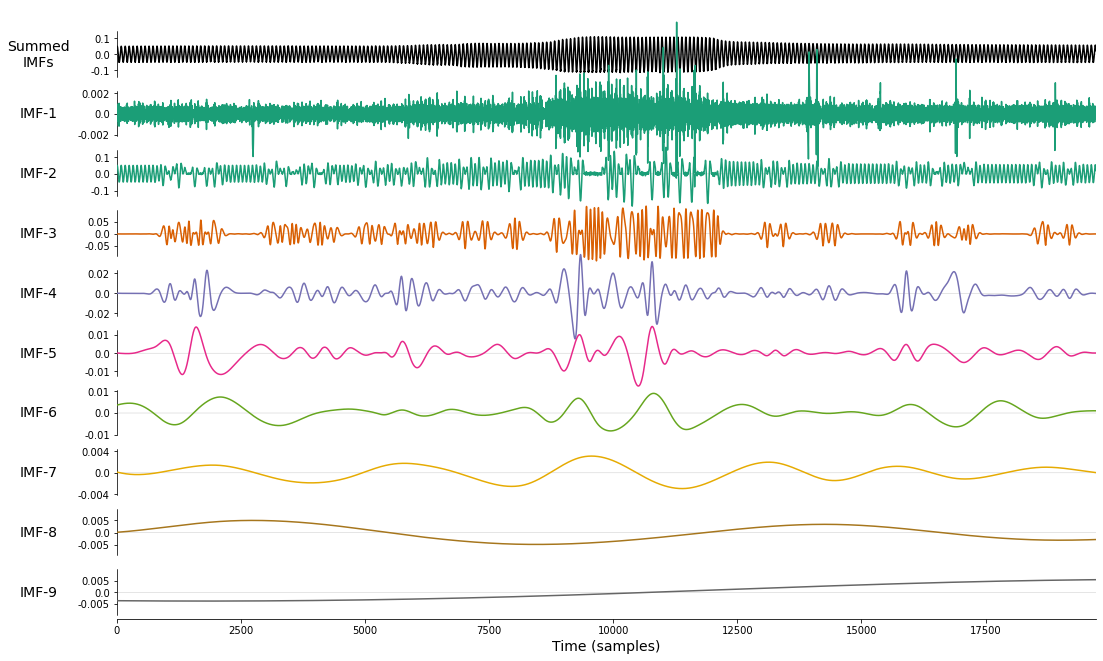

In [297]:
# EMD
import emd
seconds = 5
num_samples = seconds*sampling_rate

imf = emd.sift.sift(y - y.mean())
envelope = emd.sift.interp_envelope(imf, mode='upper')

plt.plot(envelope)
plt.xlim(8000,9000)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

Text(0.5, 1.0, 'FFT after bandpass filtering')

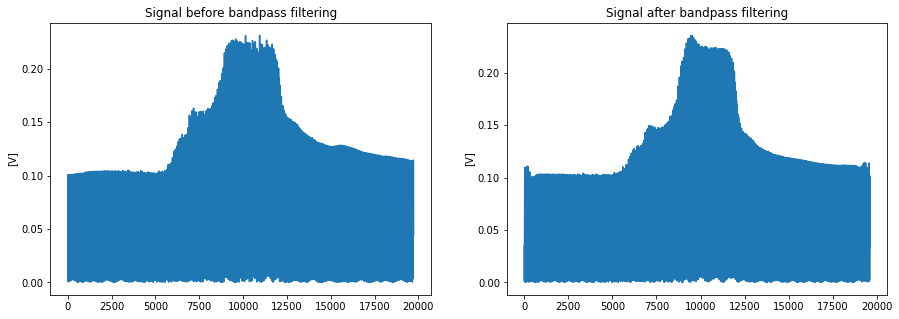

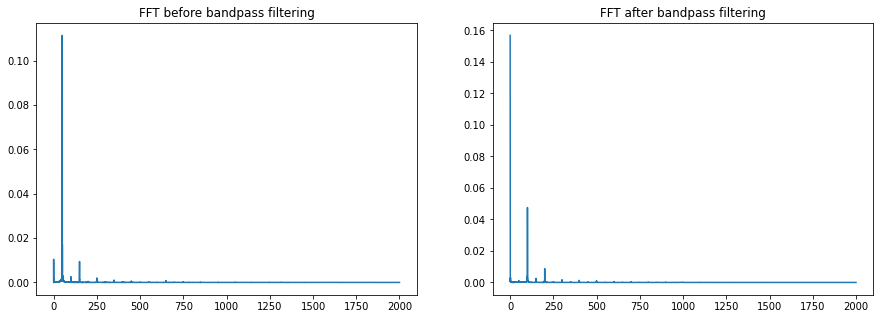

In [290]:
# Bandpass filter
from scipy import signal
high = 7/(sampling_rate/2)         # Normalized to Nyquist rate
low = 400/(sampling_rate/2)
b, a = scipy.signal.butter(4, [high,low], btype='bandpass')
y_butter = scipy.signal.filtfilt(b, a, y)
y_butter = abs(y_butter)

y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y[1:]))
plt.title('Signal before bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_butter[100:])
plt.title('Signal after bandpass filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before bandpass filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_butter_fft[:N//2]))
plt.title('FFT after bandpass filtering')


Text(0.5, 1.0, 'FFT after notch filtering')

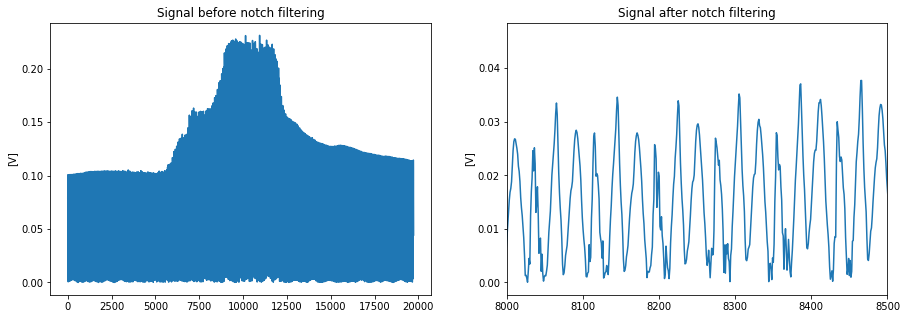

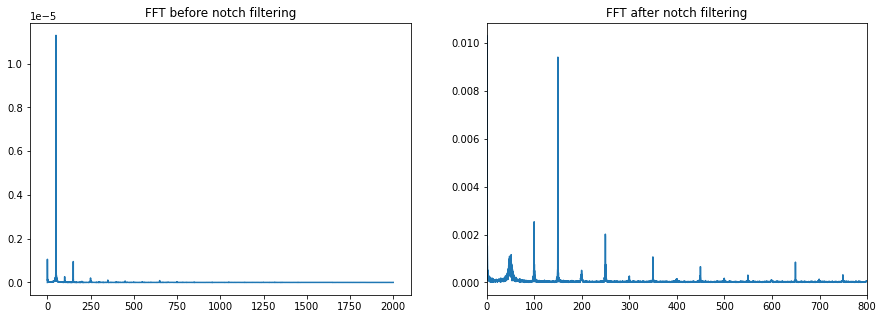

In [321]:
# Notch filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, sampling_rate)

freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)

y_notched = scipy.signal.filtfilt(b_notch, a_notch, y)
y_notched_fft = scipy.fftpack.fft(y_notched)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y[1:]))
plt.title('Signal before notch filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched[100:]))
plt.xlim(8000, 8500)
plt.title('Signal after notch filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
# plt.xlim(0, 800)
plt.title('FFT before notch filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_notched_fft[:N//2]))
plt.xlim(0, 800)
plt.title('FFT after notch filtering')

Text(0, 0.5, '[V]')

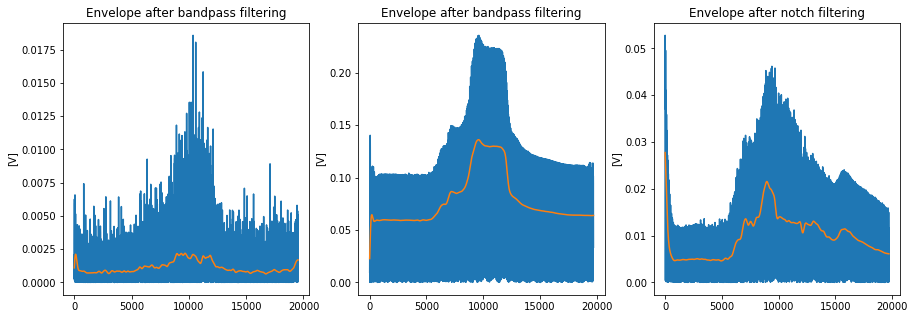

In [326]:
# Envelope
low_pass = 10/(sampling_rate/2)
b, a = scipy.signal.butter(3, low_pass, btype='lowpass')
envelope_b = scipy.signal.filtfilt(b, a, abs(y_butter))
envelope_n = scipy.signal.filtfilt(b, a, abs(y_notched))

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y_butter))
plt.plot(envelope_b)
plt.title('Envelope after bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.plot(envelope_n)
plt.title('Envelope after notch filtering')
plt.ylabel('[V]')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

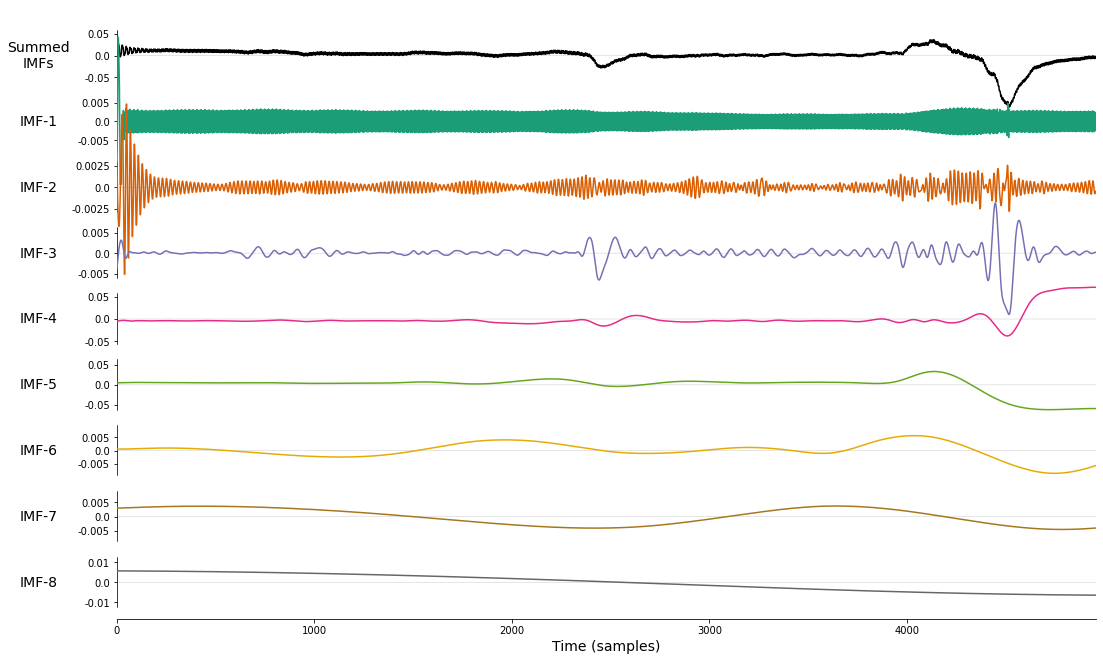

In [130]:
imf = emd.sift.sift(y_notched)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)